In [1]:
import sys
from pathlib import Path
from itertools import combinations
from collections import Counter
import pandas as pd
import numpy as np

sys.path.append('../src')
from tree import PairwiseDistanceMatrix, Dendrogram

In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.stats import gaussian_kde
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

In [3]:
def find_all_profiles(dirpath):
    return (i for i in dirpath.iterdir())

def concat_profiles(all_profiles):
    return pd.concat((pd.read_csv(profile, sep='\t', header=0, index_col=0, names=[profile.stem]) for profile in all_profiles), axis=1)

In [4]:
with open('/media/Central_Lab_Storage/NcbiASM/Vibrio_cholerae/selected.txt') as f:
    accs = f.read().split()
df = pd.DataFrame(combinations(accs, 2), columns=['query', 'subject'])
df.shape

(1081185, 2)

In [6]:
threshold = 5

In [7]:
dirpath = Path('/media/Central_Lab_Storage/NcbiASM/Vibrio_cholerae/Profile')
profile = concat_profiles(find_all_profiles(dirpath))

distmatrix = PairwiseDistanceMatrix(profile)()
labels = fcluster(linkage(squareform(distmatrix)), t=threshold + 1 , criterion='distance')
cluster_map = dict(zip(distmatrix.columns, labels))

df['relation_true'] = ['intra' if cluster_map[i]==cluster_map[j] else 'inter' for i, j in zip(df['query'], df['subject'])]
df['distance_true'] = [distmatrix.at[i, j] for i, j in zip(df['query'], df['subject'])]

In [8]:
dirpath = Path('/media/Central_Lab_Storage/NcbiASM/Vibrio_cholerae/Profile_with_Diamond')
profile = concat_profiles(find_all_profiles(dirpath))

distmatrix = PairwiseDistanceMatrix(profile)()
labels = fcluster(linkage(squareform(distmatrix)), t=threshold + 1, criterion='distance')
cluster_map = dict(zip(distmatrix.columns, labels))

df['relation_pred'] = ['intra' if cluster_map[i]==cluster_map[j] else 'inter' for i, j in zip(df['query'], df['subject'])]
df['distance_pred'] = [distmatrix.at[i, j] for i, j in zip(df['query'], df['subject'])]

In [47]:
y_true = df['relation_true']
y_pred = df['relation_pred']

cm = confusion_matrix(y_true, y_pred, labels=['intra', 'inter'])

In [51]:
precision, recall, fbeta_score, support = precision_recall_fscore_support(y_true, y_pred, labels=['intra', 'inter'])
precision, recall, fbeta_score, support

(array([0.99844294, 0.99999914]),
 array([0.9978032 , 0.99999939]),
 array([0.99812297, 0.99999927]),
 array([   21850, 55888175]))

[Text(0, 0.5, 'intra'), Text(0, 1.5, 'inter')]

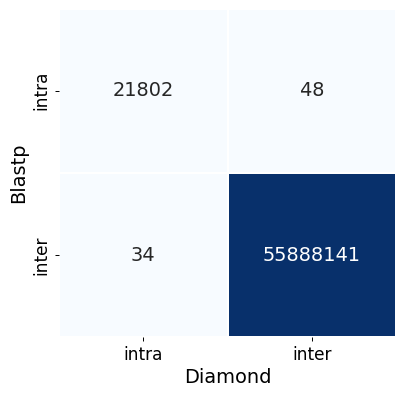

In [49]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=87)
g = sns.heatmap(
    cm,
    cmap='Blues',
    ax=ax,
    annot=True,
    fmt='', 
    annot_kws={'fontsize':16},
    linewidths=.8,
    xticklabels=['intra', 'inter'],
    yticklabels=['intra', 'inter'],
    cbar=False
)
# ax.set_title('Salmonella enterica', fontsize=20)
ax.set_xlabel('Diamond', fontsize=16)
ax.set_ylabel('Blastp', fontsize=16)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontdict={'size': 14})
ax.set_yticklabels(ax.get_ymajorticklabels(), fontdict={'size': 14})
# ax.text(1.05, 0.5, f"precision: {precision: .3f}", transform=ax.transAxes, fontsize=16)

In [50]:
fig.savefig('/media/GenomicResearch/Issue/blastp_vs_diamond/Sal.png', facecolor='w', dpi=300, bbox_inches='tight')

In [12]:
df['distance_changes'] = df['distance_pred'] - df['distance_true']

In [18]:
df_2 = df.groupby(['distance_true', 'distance_changes']).size().reset_index().rename(columns={0: 'size'})

<AxesSubplot:xlabel='distance_true', ylabel='distance_changes'>

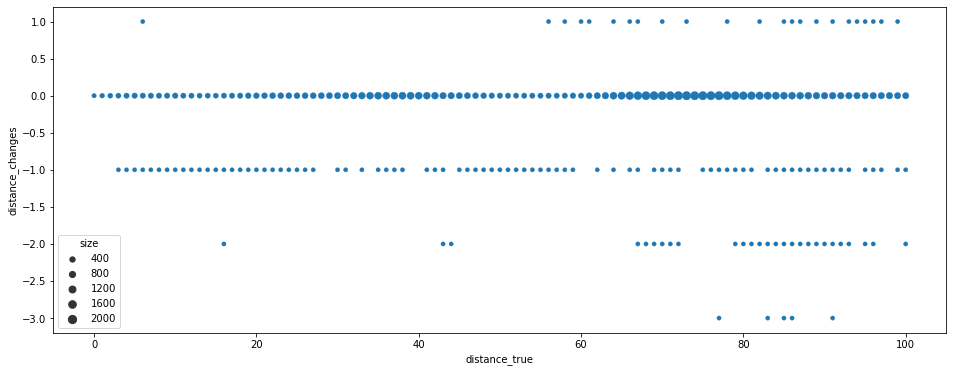

In [57]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.scatterplot(
    x='distance_true',
    y='distance_changes',
    size='size',
    data=df_2[df_2['distance_true']<=100],
    ax=ax,
    edgecolor=None
)

In [49]:
df[(df['distance_true']==0)&(df['distance_changes']==0)]

,query,subject,relation_true,distance_true,relation_pred,distance_pred,distance_changes
13661,GCA_002098355.1,GCA_002097765.1,intra,0.0,intra,0.0,0.0
36796,GCA_002078795.1,GCA_002078815.1,intra,0.0,intra,0.0,0.0
37538,GCA_002078795.1,GCA_002078825.1,intra,0.0,intra,0.0,0.0
37881,GCA_002078795.1,GCA_002078715.1,intra,0.0,intra,0.0,0.0
53486,GCA_900604905.1,GCA_008087125.1,intra,0.0,intra,0.0,0.0
...,...,...,...,...,...,...,...
1024873,GCA_002098295.1,GCA_002098965.1,intra,0.0,intra,0.0,0.0
1041377,GCA_015686715.1,GCA_015686745.1,intra,0.0,intra,0.0,0.0
1043211,GCA_000275645.1,GCA_902385755.1,intra,0.0,intra,0.0,0.0
1053892,GCA_002099115.1,GCA_002098965.1,intra,0.0,intra,0.0,0.0
